In [1]:
%reload_ext autoreload
%autoreload 2

# TAVT Tests

We need to reverse engineer Albert to understand why our model isn't working on the classification task. Many of my conclusions from the first set of vision transformer training should still hold. 

In [2]:
import timm
import torch

device = 1
bs, c, h, w = 2, 3, 224, 224
def get_nparams(m, no_betas=False):
    if no_betas:
        params = [v for k,v in m.named_parameters() if "betas" not in k]
    else:
        params = list(m.parameters())

    return sum(p.numel() for p in params)

/gpfs/u/home/DAMT/DAMThvrb/scratch/miniconda3-ppc/envs/timm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TAVT00

#### Base ALBERT

In [3]:
model = timm.create_model("avt_base_patch16_224").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams_og = get_nparams(model)
    print(nparams_og)
nparams_q = get_nparams(model.blocks.block.attn.q_proj)
nparams_k = get_nparams(model.blocks.block.attn.k_proj)
nparams_v = get_nparams(model.blocks.block.attn.v_proj)
nparams_qkv = nparams_q + nparams_k + nparams_v

8601064


In [4]:
[k for k,v in model.blocks.block.attn.proj.named_parameters()]

['weight', 'bias']

#### No Proj

In [18]:
model = timm.create_model("tavt_noproj").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

8010472


#### symmlp

In [19]:
model = timm.create_model("tavt_symmlp").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    print(get_nparams(model))

6241768


In [20]:
[k for k,v in model.blocks.block.mlp.mlp.named_parameters()]

['weight', 'bias_hid', 'bias_vis']

#### nobias

In [21]:
model = timm.create_model("tavt_nobias").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    print(get_nparams(model))

8594152


#### parallel

In [22]:
model = timm.create_model("tavt_parallel").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

8599528


In [23]:
nparams_lnorm = get_nparams(model.blocks.block.norm1)

In [24]:
# Make sure this aligns with the number of parameters in the OG albert
print(nparams + nparams_lnorm)

8601064


#### ReLU

In [25]:
model = timm.create_model("tavt_relu").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

8601064


#### elnorm

In [26]:
model = timm.create_model("tavt_elnorm").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

8598763


In [27]:
nparams_elnorm = get_nparams(model.blocks.block.norm1)
print(nparams+(3*(nparams_elnorm-2)))
# 2 in attention, 1 in ViT (nmissing from gamma)

8601064


#### newatt

In [28]:
model = timm.create_model("tavt_newatt").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
assert ((nparams_og - nparams) - (2*nparams_V)) == 0

7419880


#### BASE0

Combining all the features into something that makes sense for our regime

In [29]:
model = timm.create_model("tavt_base0").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

5057514


#### BASE0 w/ Alpha

In [30]:
model = timm.create_model("tavt_base0_alpha").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

5057514


#### BASE0 w/ Alpha and no bias

In [31]:
model = timm.create_model("tavt_base0_alpha_nobias").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

5052138


# TAVT01 Models

#### newatt_nobias_noproj

In [32]:
model = timm.create_model("tavt_noproj_nobiases").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)

8004328


#### kisv

In [33]:
model = timm.create_model("tavt_kisv").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
# assert ((nparams_og - nparams) - (2*nparams_V)) == 0

8004328


#### kisv, noproj

In [34]:
model = timm.create_model("tavt_kisv_noproj").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
# assert ((nparams_og - nparams) - (2*nparams_V)) == 0

7414504


#### kqisv

In [35]:
model = timm.create_model("tavt_kqisv").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
# assert ((nparams_og - nparams) - (2*nparams_V)) == 0

8004328


#### kqisv, no proj

In [36]:
model = timm.create_model("tavt_kqisv_noproj").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
# assert ((nparams_og - nparams) - (2*nparams_V)) == 0

7414504


#### kqisvt1

In [37]:
model = timm.create_model("tavt_kqisvt1").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
# assert ((nparams_og - nparams) - (2*nparams_V)) == 0

8004328


#### kqisvt1, noproj

In [38]:
model = timm.create_model("tavt_kqisvt1_noproj").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)
# assert ((nparams_og - nparams) - (2*nparams_V)) == 0

7414504


#### newatt_nobias

In [39]:
model = timm.create_model("tavt_newatt_nobiases").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)
    
nparams_V = get_nparams(model.blocks.block.attn.q_proj)

7414504


#### tavt_newatt_nobiases_hmix

In [40]:
model = timm.create_model("tavt_newatt_nobiases_hmix").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

7414648


#### tavt_newatt_nobiases_hmix_proj

In [41]:
model = timm.create_model("tavt_newatt_nobiases_hmix_proj").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

8004472


In [42]:
W = model.blocks.block.attn.headmixer.weight @ model.blocks.block.attn.headmixer.weight.T

In [43]:
W = model.blocks.block.attn.proj.weight

#### tavt_newatt_nobiases_proj

In [44]:
model = timm.create_model("tavt_newatt_nobiases_proj").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

8004328


#### tavt_newatt_nobiases_weightsum

In [45]:
model = timm.create_model("tavt_newatt_nobiases_weightsum").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model, no_betas=True)
    print(nparams)

7414516


## Test energy function

In [65]:
def get_hidden_states(model, x):
    self = model
    x = self.patch_embed(x)
    if self.cls_token is not None:
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
    x = self.pos_drop(x + self.pos_embed)
    block = self.blocks.block
    hidden_features = [x]
    for i in range(len(self.blocks)):
        x = block(x)
        hidden_features.append(x)
    x = self.norm(x)
    return x, hidden_features

def energy(model, x):
    block = model.blocks.block
    g = model.norm(x)
    return block.attn.energy(g) + block.mlp.energy(g)

def energy_attn(model, x):
    block = model.blocks.block
    g = model.norm(x)
    return block.attn.energy(g)

In [66]:
model = timm.create_model("tavt_base0_alpha_nobias").to(device)
model.blocks.depth = 100

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    x, xs = get_hidden_states(model, x)
    samp = torch.stack([z[:1] for z in xs])
    samp_energies = torch.vstack([energy(model, z) for z in samp])

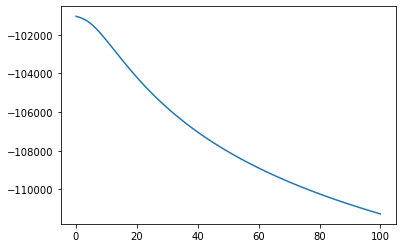

In [67]:
import matplotlib.pyplot as plt
plt.plot(samp_energies[:,1].detach().cpu().numpy())

In [49]:
# Manual check ATTN
model = timm.create_model("tavt_base0_alpha").to(device)
z = x.clone()
z.requires_grad_(True)
ga_auto = model.blocks.block.norm1(x)
ga_auto.requires_grad_(True).retain_grad()
out = (model.blocks.block.attn.energy(ga_auto)).sum()
out.backward()

with torch.no_grad():
    ga_man = model.blocks.block.attn(ga_auto)
    dga = ga_auto.grad - (-ga_man)

# Close enough
print(dga.abs().max(), dga.abs().mean())

tensor(8.3447e-07, device='cuda:1') tensor(1.2186e-07, device='cuda:1')


In [50]:
# Manual check MLP
ga_auto.grad.zero_()

z = x.clone()
z.requires_grad_(True)
ga_auto = model.blocks.block.norm1(x)
ga_auto.requires_grad_(True).retain_grad()
out = (model.blocks.block.mlp.energy(ga_auto)).sum()
out.backward()

with torch.no_grad():
    # Bias_vis is an issue
    model.blocks.block.mlp.mlp.bias_vis.zero_()
    ga_man = model.blocks.block.mlp(ga_auto)

dga = ga_auto.grad - (-ga_man)
print(dga.abs().max(), dga.abs().mean())

tensor(0., device='cuda:1') tensor(0., device='cuda:1')


# TAVT02 Testing

In [51]:
model = timm.create_model("tavt_newatt_nobiases_weightsum").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

7414528


In [52]:
model = timm.create_model("tavt_newatt_weightsum_eneg3clipinit").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

7414528


In [53]:
model = timm.create_model("tavt_newatt_weightsum_eneg4clipinit").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

7414528


In [54]:
[k for k,v in model.named_parameters() if "sum" in k]

['blocks.block.attn.weight_sum']

# TAVT03 Testing

In [5]:
# model = timm.create_model("tavt_newatt_nobiases_hmix_ortho").to(device)

# with torch.no_grad():
#     x = torch.randn((bs,c,h,w),device=device)
#     y = model(x)
#     nparams = get_nparams(model)
#     print(nparams)

In [14]:
model = timm.create_model("tavt_newatt_nobiases_hmix_ortho2").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

7414672


In [15]:
model.blocks.block.attn.headmixer.parametrizations.weight[0].L

Parameter containing:
tensor([0.4892, 0.7217, 0.6791, 0.5326, 0.8809, 0.6184, 0.7341, 0.5529, 0.4514,
        0.7077, 0.4680, 0.5751], device='cuda:1', requires_grad=True)

In [91]:
model = timm.create_model("tavt_newatt_1head_nobiases").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

6333161


In [92]:
model = timm.create_model("tavt_newatt_1head_nobiases_weightsum").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

6333162


In [93]:
model = timm.create_model("tavt_newatt_1head_fulldim_nobiases_weightsum").to(device)

with torch.no_grad():
    x = torch.randn((bs,c,h,w),device=device)
    y = model(x)
    nparams = get_nparams(model)
    print(nparams)

7414506
